# Exercise 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

## Question 1

Calculate the past 20 ka bottom water oxygen isotope signal, $\mathrm{\delta^{18}O_{SW}}$, using:

$$
\delta^{18}O_{SW} = \delta^{18}O_{C} + 0.27 - \frac{4.38 - \sqrt{4.38^2 - 4 * 0.1(16.9 - T)}}{2 * 0.1} - \delta^{18}O_{ice}
$$

Where $\delta^{18}O_{C}$ is the raw signal in benthic foram carbonate, $\delta^{18}O_{ice}$ is the ice volume correction, and $T$ is the temperature of calcification determined from an indepent Mg/Ca proxy via:

$$
T = \frac{Mg/Ca - 0.96}{0.12}
$$

In [2]:
df = pd.read_csv('data/RaPiD-10-1P_M_barleeanuum.csv', index_col=0)

In [3]:
# Find independent temperature of calcification
df['Temp'] = (df.Mg_Ca - 0.96)/0.12

# Find delta-18-O of seawater
df['d18Osw'] = df.d18Oc + 0.27 - (4.38 - (4.38**2 - 4 * 0.1 * (16.9 - df.Temp))**0.5) / (2*0.1) - df.d18Oice

Make a plot of $T$ and $\delta^{18}O_{SW}$.

Mg/Ca measurements are determined to be significantly contaminated by silicate material if $ \frac{Fe/Ca}{Mg/Ca} > 0.1 $, and must be rejected.

In [4]:
# Determine contaminated
df['bad'] = (df.Fe_Ca/df.Mg_Ca) > 0.1

### $\mathrm{T}$ x $\mathrm{\delta^{18}O_{SW}}$

(<matplotlib.text.Text at 0xaba40b8c>, <matplotlib.text.Text at 0xaba55c0c>)

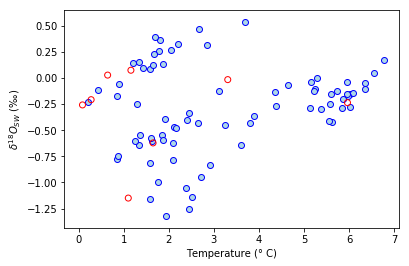

In [5]:
fig, ax = plt.subplots()
# Ensure bad points plotted on top of good
for subset, facecolors, edgecolors in zip((~df.bad, df.bad),
                                          ('lightblue', 'none'),
                                          ('blue', 'red')):
    ax.scatter(*df[['Temp', 'd18Osw']][subset].T.values,
               edgecolors=edgecolors, facecolors=facecolors)
ax.set_xlabel('Temperature (\u00B0 C)')
ax.set_ylabel('$\delta^{18}O_{SW}$ (\u2030)')